<a href="https://colab.research.google.com/github/balnarendrasapa/mask-detection/blob/master/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

- Building a pytorch model that can predict whether the person in the image is wearing a mask or not. This is mainly done using transfer learning.
- You do not need to do anything other than uploading the `kaggle.json` file to the runtime
- The Dataset is taken from the kaggle which is opensource.
- Dataset will be downloaded and paths are set accordingly.



# Download the dataset

- get kaggle.json from your kaggle account so that kaggle can download the dataset and upload it to the google colab runtime before running any cell

In [1]:
# get kaggle.json and upload it to runtime. upload kaggle.json before running this cell
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 95% 313M/330M [00:03<00:00, 85.7MB/s]
100% 330M/330M [00:03<00:00, 111MB/s] 


In [ ]:
!unzip face-mask-12k-images-dataset.zip

In [5]:
root_dir = "Face Mask Dataset/"

In [24]:
import warnings
warnings.filterwarnings("ignore")

# Dataset Preprocessing

- load the dataset using inbuild ImageFolder method
- define datasets for train, test, validation

In [54]:
from torchvision.transforms import transforms

transform=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

In [55]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

In [56]:
train_dataset = ImageFolder(root_dir+"Train", transform = transform)
test_dataset = ImageFolder(root_dir+"Test", transform = transform)
validation_dataset = ImageFolder(root_dir+"Validation", transform = transform)

In [57]:
num_classes = len(train_dataset.classes)
print(train_dataset.classes)

['WithMask', 'WithoutMask']


In [58]:
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)
print(validation_dataset.class_to_idx)

{'WithMask': 0, 'WithoutMask': 1}
{'WithMask': 0, 'WithoutMask': 1}
{'WithMask': 0, 'WithoutMask': 1}


# Define Dataloaders

In [59]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
validation_loader = DataLoader(validation_dataset, batch_size = 64, shuffle = False)

# Download the pretrained model

- I am building classifier using VGG19

In [60]:
from torchvision import models

pretrained_model = models.vgg19(pretrained=True)

In [61]:
pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Creating Custom model

- Gradients for all the layers in the pretrained model are set to `False`.

In [62]:
for params in pretrained_model.parameters():
    params.requires_grad = False

In [63]:
import torch.nn as nn

### Adding Flatten, Linear, Sigmoid to the pretrained model

- Adding these flatten, linear, sigmoid to the pretrained model by defining new neural network.
- Now the gradients for all the layers in the pretrained model are set to `False`. Which means, we only train the parameters of the new layers i.e., flatten, linear, sigmoid.

In [64]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            pretrained_model,
            nn.Flatten(),
            nn.Linear(1000, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [65]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNet()

model

NeuralNet(
  (model): Sequential(
    (0): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Training the model

In [66]:
!pip install torcheval

In [67]:
from torch import optim
from tqdm import tqdm
from torcheval.metrics.functional import binary_accuracy

criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
model.to(device)

num_epochs = 5
for epoch in tqdm(range(num_epochs)):
    training_accuracy = 0
    for inputs, labels in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs.to(device))
        outputs = outputs.squeeze()
        labels = torch.tensor(labels, dtype = torch.float).to(device)

        training_accuracy = binary_accuracy(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    testing_accuracy = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            labels = torch.tensor(labels, dtype = torch.float).to(device)

            testing_accuracy = binary_accuracy(outputs, labels)
            val_loss = criterion(outputs.squeeze(), torch.tensor(labels, dtype = torch.float).to(device))

    print(f"\nEpoch {epoch + 1}/{num_epochs} \n")
    print(f"Training Accuracy: {training_accuracy * 100} %, Training Loss: {loss.item()} \n")
    print(f"Validation Accuracy: {testing_accuracy * 100} %, Validation Loss: {val_loss.item()} \n")

    print(f"------------------------------------------------------------------------")


 20%|██        | 1/5 [00:59<03:57, 59.28s/it]


Epoch 1/5 

Training Accuracy: 100.0 %, Training Loss: 0.004842638969421387 

Validation Accuracy: 100.0 %, Validation Loss: 0.00726672075688839 

------------------------------------------------------------------------


 40%|████      | 2/5 [01:55<02:53, 57.75s/it]


Epoch 2/5 

Training Accuracy: 100.0 %, Training Loss: 0.0017505278810858727 

Validation Accuracy: 100.0 %, Validation Loss: 0.007378638256341219 

------------------------------------------------------------------------


 60%|██████    | 3/5 [02:51<01:53, 56.80s/it]


Epoch 3/5 

Training Accuracy: 100.0 %, Training Loss: 0.007849548943340778 

Validation Accuracy: 100.0 %, Validation Loss: 0.003620171919465065 

------------------------------------------------------------------------


 80%|████████  | 4/5 [03:47<00:56, 56.35s/it]


Epoch 4/5 

Training Accuracy: 100.0 %, Training Loss: 0.02799295075237751 

Validation Accuracy: 100.0 %, Validation Loss: 0.0034669952001422644 

------------------------------------------------------------------------


100%|██████████| 5/5 [04:42<00:00, 56.58s/it]


Epoch 5/5 

Training Accuracy: 100.0 %, Training Loss: 0.024092575535178185 

Validation Accuracy: 100.0 %, Validation Loss: 0.0008705169311724603 

------------------------------------------------------------------------


# Metrics

- I have used Binary Cross Entropy to calculate the loss.
- As we can see, the validation loss is 0.0008.
- And the validation accuracy is nearly 100.0 %. This means the model is good at distinguishing between masked and unmasked people

# Saving the model

- You can download the model by running below cells
- the model will be saved as `mask_detection.pth`

In [69]:
torch.save(model.state_dict(), "mask_detection.pth")

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNet()

model.load_state_dict(torch.load("mask_detection.pth"))

model = model.to(device)

# Testing the model on test images

In [72]:
import os
import random

images_with_mask = os.listdir("Face Mask Dataset/Test/WithMask")
images_without_mask = os.listdir("Face Mask Dataset/Test/WithoutMask")

images = ["WithMask/" + i for i in images_with_mask] + ["WithoutMask/" + i for i in images_without_mask]

- Here the code randomly selects an 10 images from the test folder and passes it the model

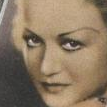

Person in the pic does not have mask
----------------------------



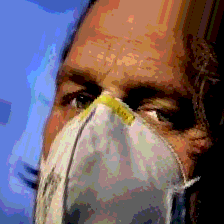

Person in the pic has mask
----------------------------



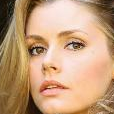

Person in the pic does not have mask
----------------------------



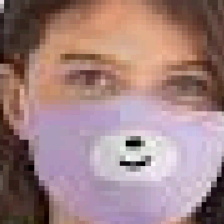

Person in the pic has mask
----------------------------



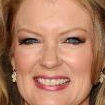

Person in the pic does not have mask
----------------------------



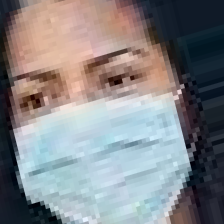

Person in the pic has mask
----------------------------



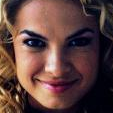

Person in the pic does not have mask
----------------------------



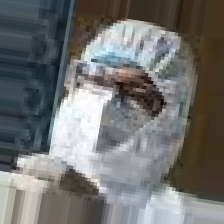

Person in the pic has mask
----------------------------



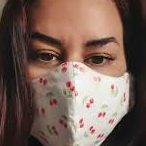

Person in the pic has mask
----------------------------



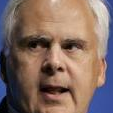

Person in the pic does not have mask
----------------------------



In [75]:
from PIL import Image

index = 10
dir = root_dir + "Test/"
for _ in range(index):
    image = Image.open(dir + random.choice(images)) # random choice
    input = transform(image).unsqueeze(0)
    output = model(input.to(device))
    probability = output.item()
    display(image)
    if probability < 0.5:
        print("Person in the pic has mask\n----------------------------\n")

    else:
        print("Person in the pic does not have mask\n----------------------------\n")
